In [1]:
# script to run simulations of stream peppering
import os, os.path
import csv
import time
import pickle
import matplotlib
#matplotlib.use('agg')
import numpy
from scipy import integrate, interpolate
from optparse import OptionParser
from galpy.util import bovy_conversion
import gd1_util
import pal5_util
from gd1_util import R0,V0
from scipy.integrate import quad
from scipy.optimize import brentq
import GMC_GC_util
import glob
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
%pylab inline
from galpy.orbit import Orbit
from scipy import ndimage, signal, interpolate
from numpy.polynomial import Polynomial
from gd1_util_MWhaloshape import lb_to_phi12

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Do a Epanechnikov KDE estimate of the PDF in the transformed y=(1+x)/(1-x) space
def kde_epanechnikov_rate(x,h,ydata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((1.1+x)/(1.1-x))
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*(1./(1.1+x)+1./(1.1-x))

def kde_epanechnikov_rate1(x,h,ydata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    #h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    #y= numpy.log((1.1+x)/(1.1-x))
    y= numpy.log((1.6+x)/(1.1-x))
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*(1./(x-(-1.5-0.1))+1./(1.1-x))


def kde_epanechnikov_slope(x,h,ydata):
    
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((2.6+x)/(-1.4-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*np.abs(1./(2.6+x) - 1./(1.4+x))

def kde_epanechnikov_amp(x,h,ydata):
    
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((1.1+x)/(1.1-x))
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*(1./(1.1+x)+1./(1.1-x))

def kde_epanechnikov_mwdm(x,h,ydata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((x-(0.01-0.005))/(1.1-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*np.abs(1./(x-(0.01-0.005)) + 1./(1.1-x))

def kde_epanechnikov_weighted_mwdm_uniform(x,h,xdata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    ydata=numpy.log((xdata-(1. - 0.1))/(30.1-xdata))
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((x-(1.-0.1))/(30.1-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.)/xdata**2.,axis=1)/h*np.abs(1./(x-(1.-0.1)) + 1./(30.1-x))

def kde_epanechnikov_loguniform_mwdm(x,h,xdata):
    
    h= numpy.ones_like(x)*h
    ydata=numpy.log((xdata-(0. - 0.1))/(np.log10(49.5)+0.1-xdata))
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((x-(0.-0.1))/(np.log10(50.)+0.1-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*np.abs(1./(x-(0.-0.1)) + 1./(np.log10(49.5)+0.1-x))


import seaborn as sns
def plot_pdf(rate_array,xloc,yloc,dat_type='rate',color=sns.color_palette()[0],zorder=8,
                  kernel_width=0.8,fontsize=16,
                  add_68peak_95up=False,add_95up=False,add_95low=False,
                  overplot=False,
                  scale=1.,label=''):
    
    rate_full= np.array(rate_array)#abc_full[sindx,0]
    
    if dat_type == 'rate':
        xxs= numpy.linspace(-1.45,1.,101)
        kdey_full= kde_epanechnikov_rate1(xxs,kernel_width,numpy.log((1.6+rate_full)/(1.1-rate_full)))+numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            #sindx= numpy.argsort(-kdey_full) # minus reverses sort
            #cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            #m68= xxs[sindx][cp > 0.68]
            #uplim68= numpy.amin(m68[m68 > bf])
            #lowlim68= numpy.amax(m68[m68 < bf])
            
            uplim68 = np.percentile(rate_full,q=84,interpolation='midpoint')
            lowlim68 = np.percentile(rate_full,q=16,interpolation='midpoint')
            #cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            uplim_95 = np.percentile(rate_full,q=95,interpolation='midpoint')
            #bovy_plot.bovy_text(r'$\mathrm{rate} = %.1f^{+%.1f}_{-%.1f} \times \mathrm{CDM}\ (68\,\%%)$' \
            #                    % (10.**bf,10.**uplim68-10.**bf,10.**bf-10.**lowlim68)+'\n'+r'$\mathrm{rate} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10**uplim_95),
            #                    size=16.,top_left=True)
            
            text(xloc,yloc,r'$\mathrm{rate} = %.1f^{+%.1f}_{-%.1f} \times \mathrm{CDM}\ (68\,\%%)$' \
                              % (10.**bf,10.**uplim68-10.**bf,10.**bf-10.**lowlim68)+'\n'+r'$\mathrm{rate} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10**uplim_95),
                              fontsize=fontsize,color=color)


        if add_95up:
            # Get 95% upper limit
            #cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            uplim_95 = np.percentile(rate_full,q=95,interpolation='midpoint')
            #bovy_plot.bovy_text(r'$\mathrm{rate} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim_95),
            #                   size=16.,top_left=True)
            text(xloc,yloc,r'$\mathrm{rate} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim_95),
                               fontsize=fontsize,color=color)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            #ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            lowlim_95 = np.percentile(rate_full,q=5,interpolation='midpoint')
            #bovy_plot.bovy_text(r'$\mathrm{rate} >%.4f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**lowlim_95),
            #                   size=16.,top_left=True)
            text(xloc,yloc,r'$\mathrm{rate} >%.4f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**lowlim_95),
                               fontsize=fontsize,color=color)
        #legend(loc='lower left')
        return None
    
    elif dat_type == 'slope':
        xxs= numpy.linspace(-2.45,-1.55,101)
        kdey_full= kde_epanechnikov_slope(xxs,kernel_width,numpy.log((2.6+rate_full)/(-1.4-rate_full)))\
            +numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  

        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\alpha = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$\alpha >%.1f \ (95\,\%%)$' % (lowlim_95),
                               size=16.,top_left=True)

        #legend(loc='upper right')
        return None
    
    elif dat_type == 'amp' : 
        xxs= numpy.linspace(-1.,1.,101)
        kdey_full= kde_epanechnikov_amp(xxs,kernel_width,numpy.log((1.1+rate_full)/(1.1-rate_full)))\
            +numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            #uplim68= numpy.amin(m68[m68 > bf])
            #lowlim68= numpy.amax(m68[m68 < bf])
            uplim68 = np.percentile(rate_full,q=84,interpolation='midpoint')
            lowlim68 = np.percentile(rate_full,q=16,interpolation='midpoint')
            bovy_plot.bovy_text(r'$\mathrm{amp} = %.1f^{+%.1f}_{-%.1f} \times \mathrm{CDM}\ (68\,\%%)$' \
                                % (10.**bf,10.**uplim68-10.**bf,10.**bf-10.**lowlim68)
                                +'\n'+r'$\mathrm{amp} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim_95),
                               size=16.,top_left=True)
            
        if add_95up:
            # Get 95% upper limit
            uplim_95 = np.percentile(rate_full,q=95,interpolation='midpoint')
            #cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\mathrm{amp} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            #ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            lowlim_95 = np.percentile(rate_full,q=5,interpolation='midpoint')
            bovy_plot.bovy_text(r'$\mathrm{amp} > %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**lowlim_95),
                               size=16.,top_left=True)

                   
        #legend(loc='upper right')
        #return None
    
    elif dat_type=='mwdm':
        xxs= numpy.linspace(0.01,1.,101)
        kdey_full= kde_epanechnikov_mwdm(xxs,kernel_width,numpy.log((rate_full-(0.01 - 0.005))/(1.1-rate_full)))\
            +numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  

        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$1/m_{\mathrm{WDM}} < %.3f \ \mathrm{keV} \ (95\,\%%)$' % (uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$1/m_{\mathrm{WDM}} >%.3f \ \mathrm{keV} \ (95\,\%%)$' % (lowlim_95),
                               size=16.,top_left=True)

        #legend(loc='upper right')
        
    elif dat_type=='weighted_mwdm_uniform':
        xxs= numpy.linspace(1.,29.,201)
        kdey_full= kde_epanechnikov_weighted_mwdm_uniform(xxs,kernel_width,rate_full)+numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  

        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} < %.3f \ \mathrm{keV} \ (95\,\%%)$' % (uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} >%.3f \ \mathrm{keV} \ (95\,\%%)$' % (lowlim_95),
                               size=16.,top_left=True)
            
    elif dat_type=='loguniform_mwdm':
        xxs= numpy.linspace(0.,np.log10(50.)-0.1,101)
        kdey_full= kde_epanechnikov_loguniform_mwdm(xxs,kernel_width,rate_full)+numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  
        
        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            #cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            uplim_95 = np.percentile(rate_full,q=95,interpolation='midpoint')
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            #cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            uplim_95 = np.percentile(rate_full,q=95,interpolation='midpoint')
            #bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} < %.3f \ \mathrm{keV} \ (95\,\%%)$' % (10**uplim_95),
            #                   size=16.,top_left=True)
            text(xloc,yloc,r'$m_{\mathrm{WDM}} < %.3f \ \mathrm{keV} (95\,\%%)$' % (10.**uplim_95),
                               fontsize=fontsize,color=color)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            lowlim_95 = np.percentile(rate_full,q=5,interpolation='midpoint')
            #ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            #bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} >%.1f \ \mathrm{keV} \ (95\,\%%)$' % (10**lowlim_95),
            #                   size=16.,top_left=True)
            
            text(xloc,yloc,r'$m_{\mathrm{WDM}} >%.1f \ \mathrm{keV} \ (95\,\%%)$' % (10**lowlim_95),
                               fontsize=fontsize,color=color)

        legend(loc='lower right')
        
        
    return None



### combine based on combined tolerances amp,slope,mwdm case

In [ ]:
dir_P5 = 'dens_Omega/Pal5_ABC_amp_slope_mwdm_diff/'

P5_amp=[]
P5_slope=[]
P5_mwdm=[]
P5_diff_hi= []
P5_diff_med=[]
P5_diff_lo=[]

for ii in range(50):
    P5_abc_diff=np.loadtxt(dir_P5 + 'Pal5_ABC_loguniformamp_uniformslope_loguniformmwdm_lenthreshold0.2_barspiral_NRaoBlackwell100_{}.dat'.format(ii),delimiter=',',skiprows=1)

    NN=len(P5_abc_diff)
    for ii in range(NN):
        #print (abc_diff[ii])
        P5_slope.append(P5_abc_diff[ii][0])
        P5_amp.append(P5_abc_diff[ii][1])
        P5_mwdm.append(P5_abc_diff[ii][2])
        
        P5_diff_hi.append(P5_abc_diff[ii][4])
        P5_diff_med.append(P5_abc_diff[ii][5])
        P5_diff_lo.append(P5_abc_diff[ii][6])

#GD1
GD1_amp=[]
GD1_slope=[]
GD1_mwdm=[]

GD1_diff_tr_hi= []
GD1_diff_tr_med=[]
GD1_diff_tr_lo=[]

GD1_diff_le_hi= []
GD1_diff_le_med=[]
GD1_diff_le_lo=[]


dir2 = 'dens_Omega/sims_for_ABC_loguniformamp_uniformslope_loguniformmwdm_margTage/'

for jj in range(50):
    
    abc_diff_tr=np.loadtxt(dir2 + 'ABC_loguniform_amp_uniform_slope_loguniform_mwdm_power_diff_trailing_lenthreshold0.2_barspiral_NRaoBlackwell100_0{}.dat'.format(jj),delimiter=',',skiprows=1)
    abc_diff_le=np.loadtxt(dir2 + 'ABC_loguniform_amp_uniform_slope_loguniform_mwdm_power_diff_leading_lenthreshold0.2_barspiral_NRaoBlackwell100_0{}.dat'.format(jj),delimiter=',',skiprows=1)

    NN=len(abc_diff_tr)

    for ii in range(NN):
        #print (abc_diff[ii])
        GD1_amp.append(abc_diff_tr[ii][0])
        GD1_slope.append(abc_diff_tr[ii][1])
        GD1_mwdm.append(abc_diff_tr[ii][2])
        #Tage=abc_diff_tr[ii][3]

        #Trailing
        GD1_diff_tr_hi.append(abc_diff_tr[ii][4])
        GD1_diff_tr_med.append(abc_diff_tr[ii][5])
        GD1_diff_tr_lo.append(abc_diff_tr[ii][6])

        #Leading
        GD1_diff_le_hi.append(abc_diff_le[ii][4])
        GD1_diff_le_med.append(abc_diff_le[ii][5])
        GD1_diff_le_lo.append(abc_diff_le[ii][6])

In [ ]:
accepted_slope=[]
accepted_amp=[]
accepted_mwdm=[]

P5_tol_hi=0.5
P5_tol_med=0.4
P5_tol_lo=0.3

GD1_tol_tr_hi=0.4
GD1_tol_tr_med=0.3
GD1_tol_tr_lo=0.2

GD1_tol_le_hi=0.4
GD1_tol_le_med=0.3
GD1_tol_le_lo=0.2

for ii in range(1001000):
    
    if (GD1_diff_tr_hi[ii] < GD1_tol_tr_hi) and (GD1_diff_tr_med[ii] < GD1_tol_tr_med) and (GD1_diff_tr_lo[ii] < GD1_tol_tr_lo)\
    and (GD1_diff_le_hi[ii] < GD1_tol_le_hi) and (GD1_diff_le_med[ii] < GD1_tol_le_med) and (GD1_diff_le_lo[ii] < GD1_tol_le_lo)\
    and (P5_diff_hi[ii] < P5_tol_hi) and (P5_diff_med[ii] < P5_tol_med) and (P5_diff_lo[ii] < P5_tol_lo):
    
        accepted_slope.append(GD1_slope[ii])
        accepted_amp.append(np.log10(GD1_amp[ii]))
        accepted_mwdm.append(np.log10(GD1_mwdm[ii]))
        #accepted_Tage.append(Tage)
        
print (len(accepted_amp))        


In [ ]:
mid_amp=np.linspace(-1.0,1.0,25)
mid_slope=np.linspace(-2.5,-1.5,25)
mid_mwdm=np.linspace(0.,np.log10(50.),25)

Tage_bin=[2.5,3.5,4.5,5.5,6.5,7.5]
midTage=[3.,4.,5.,6.,7.]

bw_amp=mid_amp[1]-mid_amp[0]
bw_slope=mid_slope[1]-mid_slope[0]
bw_mwdm=mid_mwdm[1]-mid_mwdm[0]

amp_bin_edge=[mid_amp[0]-0.5*bw_amp + bw_amp*i for i in range(len(mid_amp)+1)]
slope_bin_edge=[mid_slope[0]-0.5*bw_slope + bw_slope*i for i in range(len(mid_slope)+1)]
mwdm_bin_edge=[mid_mwdm[0]-0.5*bw_mwdm + bw_mwdm*i for i in range(len(mid_mwdm)+1)]

#count_slope,bin_edge=np.histogram(accepted_slope,slope_bin_edge,density=True)
#count_amp,bin_edge=np.histogram(accepted_amp,amp_bin_edge,density=True)
#count_mwdm,bin_edge=np.histogram(accepted_1_over_mwdm,mwdm_bin_edge,density=True)
#count_Tage=np.histogram(Tage,Tage_bin,density=True)[0]
#count_Tage_all=np.histogram(Tage_all,Tage_bin,density=True)[0]

plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.hist(accepted_amp,bins=amp_bin_edge,histtype='step',density=True)
plt.xlabel(r"log$_{10}$(amp/fid CDM)")
plt.legend(loc='upper left')

plt.subplot(1,3,2)
plt.hist(accepted_slope,bins=slope_bin_edge,histtype='step',density=True)
plt.legend(loc='upper right')
plt.xlabel("slope")

plt.subplot(1,3,3)
plt.hist(accepted_mwdm,bins=mwdm_bin_edge,histtype='step',density=True)
plt.legend(loc='upper right')
#plt.ylabel("PDF")
plt.xlabel(r"log$_{10}$(mwdm)")


#plt.savefig("lognormalamp3sigma_slope_mwdm_posterior_PDF.pdf")
plt.show()



In [ ]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(18.,5.)
cmap= cm.plasma
subplot(1,3,1)

plot_pdf(accepted_amp,dat_type='amp',kernel_width=0.7,add_68peak_95up=True,add_95low=False,scale=1.,label='',overplot=True)
xlabel(r'$\log_{10}\left(\mathrm{amp}/\mathrm{fiducial\ CDM\ amp}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-1.2,1.2)
ylim(0.,1.)

subplot(1,3,2)
plot_pdf(accepted_slope,dat_type='slope',kernel_width=0.4,add_95low=False,scale=1.,label='',overplot=True)
xlabel(r'$\alpha$')
ylabel(r'$\mathrm{PDF}$')
xlim(-2.7,-1.3)
ylim(0.,1.5)

subplot(1,3,3)
plot_pdf(np.array(accepted_mwdm),dat_type='loguniform_mwdm',add_95low=True,kernel_width=0.8,scale=1.,label='',overplot=True)
xlabel(r'$\log_{10}(m_{\mathrm{WDM}}/ \mathrm{keV})$')
ylabel(r'$\mathrm{PDF}$')
xlim(-0.1,1.8)
ylim(0.,1.2)
#savefig("paper_plots/GD1_ABC_posterior_amp_slope_mwdm.pdf",bbox_inches='tight')

### Combine rate

In [ ]:
'''
dir_P5 = 'dens_Omega/Pal5_ABC_rate_diff/'

P5_rate=[]
P5_diff_hi= []
P5_diff_med=[]
P5_diff_lo=[]

for jj in range(351):
    P5_abc_diff=np.loadtxt(dir_P5 + 'Pal5_ABC_loguniform_rate_lenthreshold0.2_barspiral_NRaoBlackwell100_{}.dat'.format(jj),delimiter=',',skiprows=1)

    NN=len(P5_abc_diff)
    for ii in range(NN):
        #print (abc_diff[ii])
        P5_rate.append(P5_abc_diff[ii][0])
                
        P5_diff_hi.append(P5_abc_diff[ii][1])
        P5_diff_med.append(P5_abc_diff[ii][2])
        P5_diff_lo.append(P5_abc_diff[ii][3])
'''        
        
#GD1
GD1_rate=[]

GD1_diff_tr_hi= []
GD1_diff_tr_med=[]
GD1_diff_tr_lo=[]

GD1_diff_le_hi= []
GD1_diff_le_med=[]
GD1_diff_le_lo=[]


dir2 = 'dens_Omega/sims_for_ABC_loguniform_rate_margTage/'

for jj in range(351):
    
    abc_diff_tr=np.loadtxt(dir2 + 'ABC_uniform_rate_power_diff_trailing_lenthreshold0.2_barspiral_NRaoBlackwell100_{}.dat'.format(jj),delimiter=',',skiprows=1)
    abc_diff_le=np.loadtxt(dir2 + 'ABC_uniform_rate_power_diff_leading_lenthreshold0.2_barspiral_NRaoBlackwell100_{}.dat'.format(jj),delimiter=',',skiprows=1)

    NN=len(abc_diff_tr)

    for ii in range(NN):
        #print (abc_diff[ii])
        GD1_rate.append(abc_diff_tr[ii][0])
        
        #Trailing
        GD1_diff_tr_hi.append(abc_diff_tr[ii][2])
        GD1_diff_tr_med.append(abc_diff_tr[ii][3])
        GD1_diff_tr_lo.append(abc_diff_tr[ii][4])

        #Leading
        GD1_diff_le_hi.append(abc_diff_le[ii][2])
        GD1_diff_le_med.append(abc_diff_le[ii][3])
        GD1_diff_le_lo.append(abc_diff_le[ii][4])
        

In [ ]:
dir_P5 = 'dens_Omega/Pal5_ABC_lowrate_diff/'
dir2 = 'dens_Omega/sims_for_ABC_loguniform_lowrate_margTage/'

count = 0

for kk in range(351):
    #P5_abc_diff=np.loadtxt(dir_P5 + 'Pal5_ABC_loguniform_lowrate_lenthreshold0.2_barspiral_NRaoBlackwell100_{}.dat'.format(kk),delimiter=',',skiprows=1)
    
    abc_diff_tr=np.loadtxt(dir2 + 'ABC_uniform_lowrate_power_diff_trailing_lenthreshold0.2_barspiral_NRaoBlackwell100_{}.dat'.format(kk),delimiter=',',skiprows=1)
    abc_diff_le=np.loadtxt(dir2 + 'ABC_uniform_lowrate_power_diff_leading_lenthreshold0.2_barspiral_NRaoBlackwell100_{}.dat'.format(kk),delimiter=',',skiprows=1)

    NN=len(abc_diff_tr)
    count +=NN
    for ii in range(NN):
        #print (abc_diff[ii])
        #P5_rate.append(P5_abc_diff[ii][0])
                
        #P5_diff_hi.append(P5_abc_diff[ii][1])
        #P5_diff_med.append(P5_abc_diff[ii][2])
        #P5_diff_lo.append(P5_abc_diff[ii][3])
        
        GD1_rate.append(abc_diff_tr[ii][0])
        
        #Trailing
        GD1_diff_tr_hi.append(abc_diff_tr[ii][2])
        GD1_diff_tr_med.append(abc_diff_tr[ii][3])
        GD1_diff_tr_lo.append(abc_diff_tr[ii][4])

        #Leading
        GD1_diff_le_hi.append(abc_diff_le[ii][2])
        GD1_diff_le_med.append(abc_diff_le[ii][3])
        GD1_diff_le_lo.append(abc_diff_le[ii][4])
        
print (count)
    

In [ ]:
for jj in range(len(GD1_rate)):
    if GD1_rate[jj] != P5_rate[jj]:
        print (GD1_rate[jj],P5_rate[jj])

In [ ]:
accepted_rate=[]
accepted_rate_GD1=[]
accepted_rate_Pal5=[]

P5_tol_hi=0.3
P5_tol_med=0.2
P5_tol_lo=0.1

GD1_tol_tr_hi=0.3
GD1_tol_tr_med=0.2
GD1_tol_tr_lo=0.1

GD1_tol_le_hi=0.3
GD1_tol_le_med=0.2
GD1_tol_le_lo=0.1

#for ii in range(len(GD1_rate)):
#    
#    if (GD1_diff_tr_hi[ii] < GD1_tol_tr_hi) and (GD1_diff_tr_med[ii] < GD1_tol_tr_med) and (GD1_diff_tr_lo[ii] < GD1_tol_tr_lo)\
#    and (GD1_diff_le_hi[ii] < GD1_tol_le_hi) and (GD1_diff_le_med[ii] < GD1_tol_le_med) and (GD1_diff_le_lo[ii] < GD1_tol_le_lo)\
#    and (P5_diff_hi[ii] < P5_tol_hi) and (P5_diff_med[ii] < P5_tol_med) and (P5_diff_lo[ii] < P5_tol_lo):
#    
#        accepted_rate.append(np.log10(GD1_rate[ii]))
        
        
for ii in range(len(GD1_rate)):
    
    if (GD1_diff_tr_hi[ii] < GD1_tol_tr_hi) and (GD1_diff_tr_med[ii] < GD1_tol_tr_med) and (GD1_diff_tr_lo[ii] < GD1_tol_tr_lo)\
    and (GD1_diff_le_hi[ii] < GD1_tol_le_hi) and (GD1_diff_le_med[ii] < GD1_tol_le_med) and (GD1_diff_le_lo[ii] < GD1_tol_le_lo):
    
    
        accepted_rate_GD1.append(np.log10(GD1_rate[ii]))
'''        
for ii in range(len(GD1_rate)):
    
    if (P5_diff_hi[ii] < P5_tol_hi) and (P5_diff_med[ii] < P5_tol_med) and (P5_diff_lo[ii] < P5_tol_lo):
    
        accepted_rate_Pal5.append(np.log10(GD1_rate[ii]))
                
print (len(accepted_rate),len(accepted_rate_GD1),len(accepted_rate_Pal5))   
'''

In [ ]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,8)
#plot_pdf(accepted_rate,xloc=-0.1,yloc=1.15,dat_type='rate',kernel_width=0.7,add_68peak_95up=True,add_95low=False,scale=1.,label=r'GD-1 $\times$ Pal 5',overplot=True,color='k')
plot_pdf(accepted_rate_GD1,xloc=-0.1,yloc=0.8,dat_type='rate',kernel_width=0.7,add_68peak_95up=True,add_95low=False,scale=1.,label=r'GD-1',overplot=True,color='b')
#plot_pdf(accepted_rate_Pal5,xloc=-0.1,yloc=0.95,dat_type='rate',kernel_width=0.7,add_68peak_95up=False,add_95up=True,scale=1.,label='Pal 5',overplot=True,color='r')

xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{CDM_{fid}\ rate}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-1.6,1.4)
ylim(0.,1.0)


savefig("paper_plots/GD1_ABC_posterior_rate.pdf",bbox_inches='tight')

### combine mwdm

In [6]:
dir_P5 = 'dens_Omega/Pal5_ABC_mwdm_diff/'
dir2 = 'dens_Omega/sims_for_ABC_loguniformmwdm_margTage/'

P5_mwdm=[]
P5_diff_hi= []
P5_diff_med=[]
P5_diff_lo=[]

#GD1
GD1_mwdm=[]
GD1_diff_tr_hi= []
GD1_diff_tr_med=[]
GD1_diff_tr_lo=[]

GD1_diff_le_hi= []
GD1_diff_le_med=[]
GD1_diff_le_lo=[]

for jj in range(350):
    P5_abc_diff=np.loadtxt(dir_P5 + 'Pal5_ABC_loguniform_mwdm_lenthreshold0.2_barspiral_NRaoBlackwell100_{}.dat'.format(jj),delimiter=',',skiprows=1)
    
    abc_diff_tr=np.loadtxt(dir2 + 'ABC_loguniform_mwdm_power_12.0degcut_diff_trailing_lenthreshold0.2_barspiral_NRaoBlackwell100_{}.dat'.format(jj),delimiter=',',skiprows=1)
    abc_diff_le=np.loadtxt(dir2 + 'ABC_loguniform_mwdm_power_12.0degcut_diff_leading_lenthreshold0.2_barspiral_NRaoBlackwell100_{}.dat'.format(jj),delimiter=',',skiprows=1)

    NN=len(abc_diff_tr)
    #print (jj,len(P5_abc_diff),NN)
    for ii in range(NN):
        #print (abc_diff[ii])
        P5_mwdm.append(P5_abc_diff[ii][0])
                
        P5_diff_hi.append(P5_abc_diff[ii][1])
        P5_diff_med.append(P5_abc_diff[ii][2])
        P5_diff_lo.append(P5_abc_diff[ii][3])
        
        GD1_mwdm.append(abc_diff_tr[ii][0])
        
        #Trailing
        GD1_diff_tr_hi.append(abc_diff_tr[ii][2])
        GD1_diff_tr_med.append(abc_diff_tr[ii][3])
        GD1_diff_tr_lo.append(abc_diff_tr[ii][4])

        #Leading
        GD1_diff_le_hi.append(abc_diff_le[ii][2])
        GD1_diff_le_med.append(abc_diff_le[ii][3])
        GD1_diff_le_lo.append(abc_diff_le[ii][4])
        


In [7]:
for jj in range(len(GD1_mwdm)):
    if GD1_mwdm[jj] != P5_mwdm[jj]:
        print (jj,GD1_mwdm[jj],P5_mwdm[jj])

In [8]:
accepted_mwdm=[]
accepted_mwdm_GD1=[]
accepted_mwdm_Pal5=[]

P5_tol_hi=0.2
P5_tol_med=0.1
P5_tol_lo=0.05

GD1_tol_tr_hi=0.2
GD1_tol_tr_med=0.1
GD1_tol_tr_lo=0.05

GD1_tol_le_hi=0.2
GD1_tol_le_med=0.1
GD1_tol_le_lo=0.05

for ii in range(len(GD1_mwdm)):
    
    if (GD1_diff_tr_hi[ii] < GD1_tol_tr_hi) and (GD1_diff_tr_med[ii] < GD1_tol_tr_med) and (GD1_diff_tr_lo[ii] < GD1_tol_tr_lo)\
    and (GD1_diff_le_hi[ii] < GD1_tol_le_hi) and (GD1_diff_le_med[ii] < GD1_tol_le_med) and (GD1_diff_le_lo[ii] < GD1_tol_le_lo)\
    and (P5_diff_hi[ii] < P5_tol_hi) and (P5_diff_med[ii] < P5_tol_med) and (P5_diff_lo[ii] < P5_tol_lo):
    
        accepted_mwdm.append(np.log10(GD1_mwdm[ii]))
        
        
for ii in range(len(GD1_mwdm)):
    
    if (GD1_diff_tr_hi[ii] < GD1_tol_tr_hi) and (GD1_diff_tr_med[ii] < GD1_tol_tr_med) and (GD1_diff_tr_lo[ii] < GD1_tol_tr_lo)\
    and (GD1_diff_le_hi[ii] < GD1_tol_le_hi) and (GD1_diff_le_med[ii] < GD1_tol_le_med) and (GD1_diff_le_lo[ii] < GD1_tol_le_lo):
    
    
        accepted_mwdm_GD1.append(np.log10(GD1_mwdm[ii]))
        
for ii in range(len(GD1_mwdm)):
    
    if (P5_diff_hi[ii] < P5_tol_hi) and (P5_diff_med[ii] < P5_tol_med) and (P5_diff_lo[ii] < P5_tol_lo):
    
        accepted_mwdm_Pal5.append(np.log10(GD1_mwdm[ii]))
                
print (len(accepted_mwdm),len(accepted_mwdm_GD1),len(accepted_mwdm_Pal5))   


2 586 37281


## Test different tolerances

19 586 15048


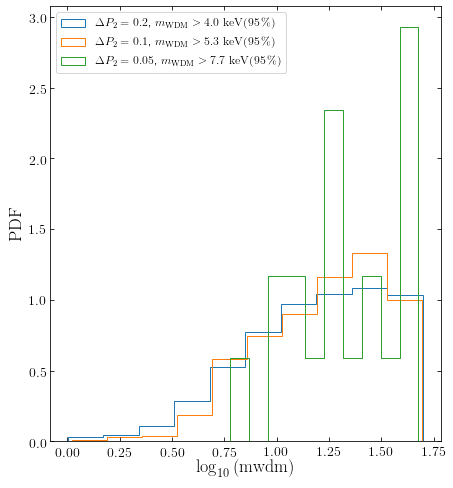

In [11]:
accepted_mwdm_GD1_0=[]
accepted_mwdm_GD1_1=[]
accepted_mwdm_GD1_2=[]


GD1_tol_hi_0=0.3
GD1_tol_med_0=0.2
GD1_tol_lo_0=0.1

GD1_tol_hi_1=0.2
GD1_tol_med_1=0.1
GD1_tol_lo_1=0.05

GD1_tol_hi_2=0.1
GD1_tol_med_2=0.05
GD1_tol_lo_2=0.025

       
for ii in range(len(GD1_mwdm)):
    
    if (GD1_diff_tr_hi[ii] < GD1_tol_hi_0) and (GD1_diff_tr_med[ii] < GD1_tol_med_0) and (GD1_diff_tr_lo[ii] < GD1_tol_lo_0)\
    and (GD1_diff_le_hi[ii] < GD1_tol_hi_0) and (GD1_diff_le_med[ii] < GD1_tol_med_0) and (GD1_diff_le_lo[ii] < GD1_tol_lo_0):
    
    
        accepted_mwdm_GD1_0.append(np.log10(GD1_mwdm[ii]))
        
    if (GD1_diff_tr_hi[ii] < GD1_tol_hi_1) and (GD1_diff_tr_med[ii] < GD1_tol_med_1) and (GD1_diff_tr_lo[ii] < GD1_tol_lo_1)\
    and (GD1_diff_le_hi[ii] < GD1_tol_hi_1) and (GD1_diff_le_med[ii] < GD1_tol_med_1) and (GD1_diff_le_lo[ii] < GD1_tol_lo_1):
    
    
        accepted_mwdm_GD1_1.append(np.log10(GD1_mwdm[ii]))
        
    if (GD1_diff_tr_hi[ii] < GD1_tol_hi_2) and (GD1_diff_tr_med[ii] < GD1_tol_med_2) and (GD1_diff_tr_lo[ii] < GD1_tol_lo_2)\
    and (GD1_diff_le_hi[ii] < GD1_tol_hi_2) and (GD1_diff_le_med[ii] < GD1_tol_med_2) and (GD1_diff_le_lo[ii] < GD1_tol_lo_2):
    
    
        accepted_mwdm_GD1_2.append(np.log10(GD1_mwdm[ii]))
        
print (len(accepted_mwdm_GD1_2),len(accepted_mwdm_GD1_1),len(accepted_mwdm_GD1_0))

mwdm_bins=np.linspace(0.,np.log10(50.),15)
midbin=np.array([0.5*(mwdm_bins[ii] + mwdm_bins[ii+1]) for ii in range(len(mwdm_bins)-1)])
count,bin_edge=np.histogram(accepted_mwdm,mwdm_bins,density=True)
#count_prior,_=np.histogram(rand_rate,rredge,density=True)

lolim_95_0 = np.percentile(np.array(accepted_mwdm_GD1_0),q=5,interpolation='midpoint')
lolim_95_1 = np.percentile(np.array(accepted_mwdm_GD1_1),q=5,interpolation='midpoint')
lolim_95_2 = np.percentile(np.array(accepted_mwdm_GD1_2),q=5,interpolation='midpoint')

plt.figure(figsize=(7,8))
plt.hist(accepted_mwdm_GD1_0,bins=10,density=True,histtype='step',label=r'$\Delta P_{2} = 0.2$, $m_{\mathrm{WDM}} > %.1f \ \mathrm{keV} (95\,\%%)$' % (10.**lolim_95_0) )
plt.hist(accepted_mwdm_GD1_1,bins=10,density=True,histtype='step',label=r'$\Delta P_{2} = 0.1$, $m_{\mathrm{WDM}} > %.1f \ \mathrm{keV} (95\,\%%)$' % (10.**lolim_95_1))
plt.hist(accepted_mwdm_GD1_2,bins=10,density=True,histtype='step',label=r'$\Delta P_{2} = 0.05$, $m_{\mathrm{WDM}} > %.1f \ \mathrm{keV} (95\,\%%)$' % (10.**lolim_95_2))
#plt.hist(mwdm_all,bins=10,density=False,histtype='step')
#plt.plot(midbin,count)
plt.xlabel(r'$\log_{10}\left(\mathrm{mwdm}\right)$')
plt.ylabel(r'$\mathrm{PDF}$')
plt.legend(loc = 'upper left')

plt.show()

(0.0, 1.4)

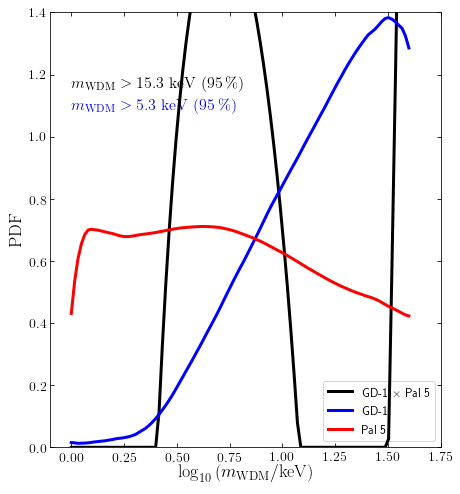

In [12]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,8)
plot_pdf(accepted_mwdm,xloc=0.,yloc=1.15,dat_type='loguniform_mwdm',kernel_width=0.75,add_68peak_95up=False,add_95low=True,scale=1.,label=r'GD-1 $\times$ Pal 5',overplot=True,color='k')
plot_pdf(accepted_mwdm_GD1,xloc=0.,yloc=1.08,dat_type='loguniform_mwdm',kernel_width=0.9,add_95low=True,scale=1.,label=r'GD-1',overplot=True,color='b')
plot_pdf(accepted_mwdm_Pal5,xloc=-0.1,yloc=0.95,dat_type='loguniform_mwdm',kernel_width=0.7,add_68peak_95up=False,add_95up=False,scale=1.,label='Pal 5',overplot=True,color='r')

xlabel(r'$\log_{10}\left(m_{\rm{WDM}}/\mathrm{keV}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-0.1,1.75)
ylim(0.,1.4)


#savefig("paper_plots/GD1_ABC_posterior_mwdm.pdf",bbox_inches='tight')

In [ ]:
accepted_mwdm = np.array(accepted_mwdm)
accepted_mwdm_GD1 = np.array(accepted_mwdm_GD1)
accepted_mwdm_Pal5 = np.array(accepted_mwdm_Pal5)

accepted_mwdm_cut=accepted_mwdm[accepted_mwdm <= np.log10(40.)]
accepted_mwdm_cut_GD1=accepted_mwdm_GD1[accepted_mwdm_GD1 <= np.log10(40.)]
#accepted_mwdm_cut_Pal5=accepted_mwdm_Pal5[accepted_mwdm_Pal5 <= np.log10(40.)]

print (len(accepted_mwdm_cut))

print (10**(np.percentile(accepted_mwdm_cut,q=5,interpolation='midpoint')))
print (10**(np.percentile(accepted_mwdm_cut_GD1,q=5,interpolation='midpoint')))
#print (10**(np.percentile(accepted_mwdm_cut,q=5,interpolation='midpoint')))



### combine 4 bins

In [ ]:
dir_P5 = 'dens_Omega/Pal5_ABC_4bin_diff/'
dir2 = 'dens_Omega/sims_for_ABC_loguniform_rate_4bin_margTage/'

P5_x1=[]
P5_x2=[]
P5_x3=[]
P5_x4=[]
P5_diff_hi= []
P5_diff_med=[]
P5_diff_lo=[]

#GD1
GD1_x1=[]
GD1_x2=[]
GD1_x3=[]
GD1_x4=[]
GD1_diff_tr_hi= []
GD1_diff_tr_med=[]
GD1_diff_tr_lo=[]

GD1_diff_le_hi= []
GD1_diff_le_med=[]
GD1_diff_le_lo=[]

for jj in range(0,350):
    P5_abc_diff=np.loadtxt(dir_P5 + 'Pal5_ABC_loguniform_4bins_lenthreshold0.2_barspiral_NRaoBlackwell100_{}.dat'.format(jj),delimiter=',',skiprows=1)
    
    abc_diff_tr=np.loadtxt(dir2 + 'ABC_4bin_minmax1_12.0degcut_power_diff_trailing_lenthreshold0.2_barspiral_NRaoBlackwell100_{}.dat'.format(jj),delimiter=',',skiprows=1)
    abc_diff_le=np.loadtxt(dir2 + 'ABC_4bin_minmax1_12.0degcut_power_diff_leading_lenthreshold0.2_barspiral_NRaoBlackwell100_{}.dat'.format(jj),delimiter=',',skiprows=1)

    NN=len(P5_abc_diff)
    for ii in range(NN):
        #print (abc_diff[ii])
        P5_x1.append(P5_abc_diff[ii][0])
        P5_x2.append(P5_abc_diff[ii][1])
        P5_x3.append(P5_abc_diff[ii][2])
        P5_x4.append(P5_abc_diff[ii][3])
                
        P5_diff_hi.append(P5_abc_diff[ii][4])
        P5_diff_med.append(P5_abc_diff[ii][5])
        P5_diff_lo.append(P5_abc_diff[ii][6])
        
        GD1_x1.append(abc_diff_tr[ii][0])
        GD1_x2.append(abc_diff_tr[ii][1])
        GD1_x3.append(abc_diff_tr[ii][2])
        GD1_x4.append(abc_diff_tr[ii][3])
        
        #Trailing
        GD1_diff_tr_hi.append(abc_diff_tr[ii][5])
        GD1_diff_tr_med.append(abc_diff_tr[ii][6])
        GD1_diff_tr_lo.append(abc_diff_tr[ii][7])

        #Leading
        GD1_diff_le_hi.append(abc_diff_le[ii][5])
        GD1_diff_le_med.append(abc_diff_le[ii][6])
        GD1_diff_le_lo.append(abc_diff_le[ii][7])
        


In [ ]:
dir_P5 = 'dens_Omega/Pal5_ABC_4bin_diff_lowrate/'
dir2 = 'dens_Omega/sims_for_ABC_loguniform_lowrate_4bin_margTage/'

count = 0

for kk in range(350):
    P5_abc_diff=np.loadtxt(dir_P5 + 'Pal5_ABC_loguniform_lowrate_4bins_lenthreshold0.2_barspiral_NRaoBlackwell100_{}.dat'.format(kk),delimiter=',',skiprows=1)
    
    abc_diff_tr=np.loadtxt(dir2 + 'ABC_lowrate_4bin_minmax1_12.0degcut_power_diff_trailing_lenthreshold0.2_barspiral_NRaoBlackwell100_{}.dat'.format(kk),delimiter=',',skiprows=1)
    abc_diff_le=np.loadtxt(dir2 + 'ABC_lowrate_4bin_minmax1_12.0degcut_power_diff_leading_lenthreshold0.2_barspiral_NRaoBlackwell100_{}.dat'.format(kk),delimiter=',',skiprows=1)

    NN=len(abc_diff_tr)
    count +=NN
    for ii in range(NN):
        #print (abc_diff[ii])
        P5_x1.append(P5_abc_diff[ii][0])
        P5_x2.append(P5_abc_diff[ii][1])
        P5_x3.append(P5_abc_diff[ii][2])
        P5_x4.append(P5_abc_diff[ii][3])
                
        P5_diff_hi.append(P5_abc_diff[ii][4])
        P5_diff_med.append(P5_abc_diff[ii][5])
        P5_diff_lo.append(P5_abc_diff[ii][6])
        
        GD1_x1.append(abc_diff_tr[ii][0])
        GD1_x2.append(abc_diff_tr[ii][1])
        GD1_x3.append(abc_diff_tr[ii][2])
        GD1_x4.append(abc_diff_tr[ii][3])
        
        #Trailing
        GD1_diff_tr_hi.append(abc_diff_tr[ii][5])
        GD1_diff_tr_med.append(abc_diff_tr[ii][6])
        GD1_diff_tr_lo.append(abc_diff_tr[ii][7])

        #Leading
        GD1_diff_le_hi.append(abc_diff_le[ii][5])
        GD1_diff_le_med.append(abc_diff_le[ii][6])
        GD1_diff_le_lo.append(abc_diff_le[ii][7])
        
print (count)
    

In [ ]:
for jj in range(len(GD1_x1)):
    if GD1_x4[jj] != P5_x4[jj]:
        print (jj,GD1_x4[jj],P5_x4[jj])

In [ ]:
accepted_x1=[]
accepted_x2=[]
accepted_x3=[]
accepted_x4=[]

accepted_x1_GD1=[]
accepted_x2_GD1=[]
accepted_x3_GD1=[]
accepted_x4_GD1=[]

accepted_x1_P5=[]
accepted_x2_P5=[]
accepted_x3_P5=[]
accepted_x4_P5=[]


P5_tol_hi=0.3
P5_tol_med=0.2
P5_tol_lo=0.1

GD1_tol_tr_hi=0.3
GD1_tol_tr_med=0.2
GD1_tol_tr_lo=0.1

GD1_tol_le_hi=0.3
GD1_tol_le_med=0.2
GD1_tol_le_lo=0.1

for ii in range(len(GD1_x1)):
    
    if (GD1_diff_tr_hi[ii] < GD1_tol_tr_hi) and (GD1_diff_tr_med[ii] < GD1_tol_tr_med) and (GD1_diff_tr_lo[ii] < GD1_tol_tr_lo)\
    and (GD1_diff_le_hi[ii] < GD1_tol_le_hi) and (GD1_diff_le_med[ii] < GD1_tol_le_med) and (GD1_diff_le_lo[ii] < GD1_tol_le_lo)\
    and (P5_diff_hi[ii] < P5_tol_hi) and (P5_diff_med[ii] < P5_tol_med) and (P5_diff_lo[ii] < P5_tol_lo):
    
        accepted_x1.append(np.log10(GD1_x1[ii]))
        accepted_x2.append(np.log10(GD1_x2[ii]))
        accepted_x3.append(np.log10(GD1_x3[ii]))
        accepted_x4.append(np.log10(GD1_x4[ii]))
        
        
for ii in range(len(GD1_x1)):
    
    if (GD1_diff_tr_hi[ii] < GD1_tol_tr_hi) and (GD1_diff_tr_med[ii] < GD1_tol_tr_med) and (GD1_diff_tr_lo[ii] < GD1_tol_tr_lo)\
    and (GD1_diff_le_hi[ii] < GD1_tol_le_hi) and (GD1_diff_le_med[ii] < GD1_tol_le_med) and (GD1_diff_le_lo[ii] < GD1_tol_le_lo):
    
    
        accepted_x1_GD1.append(np.log10(GD1_x1[ii]))
        accepted_x2_GD1.append(np.log10(GD1_x2[ii]))
        accepted_x3_GD1.append(np.log10(GD1_x3[ii]))
        accepted_x4_GD1.append(np.log10(GD1_x4[ii]))
        
for ii in range(len(GD1_x1)):
    
    if (P5_diff_hi[ii] < P5_tol_hi) and (P5_diff_med[ii] < P5_tol_med) and (P5_diff_lo[ii] < P5_tol_lo):
    
        accepted_x1_P5.append(np.log10(GD1_x1[ii]))
        accepted_x2_P5.append(np.log10(GD1_x2[ii]))
        accepted_x3_P5.append(np.log10(GD1_x3[ii]))
        accepted_x4_P5.append(np.log10(GD1_x4[ii]))
                
print (len(accepted_x1),len(accepted_x1_GD1),len(accepted_x1_P5))   

In [ ]:
plt.figure(figsize=(10,10))
ax1=plt.subplot(2,2,1)

ax1.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.,labelbottom=False) 
plot_pdf(accepted_x1,xloc=-0.3,yloc=1.1,color='k',dat_type='rate',fontsize=12,add_95up=True,add_95low=False,kernel_width=0.6,overplot=True)
plot_pdf(accepted_x1_GD1,xloc=-0.3,yloc=1.,color='b',dat_type='rate',fontsize=12,add_68peak_95up=False,add_95up=True,add_95low=False,kernel_width=0.6,overplot=True)
plot_pdf(accepted_x1_P5,xloc=-0.3,yloc=0.9,color='r',dat_type='rate',fontsize=12,add_68peak_95up=False,add_95up=True,add_95low=False,kernel_width=0.6,overplot=True)
#xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{fiducial\ CDM\ rate}\right)$')
ylabel(r'$\mathrm{PDF}$',fontsize=16)
xlim(-1.6,1.3)
ylim(-0.05,1.3)
text(-1.1,0.01,r'$10^{5}-10^{6} \ \rm{M}_{\odot}$',fontsize=18)
#plt.legend(loc='lower left',fontsize=16)
#plt.ylim(200,4200)
plt.xlabel([])
plt.xtick_labelsize=0.


ax2=plt.subplot(2,2,2)
ax2.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.,labelbottom=False) 
plot_pdf(accepted_x2,xloc=-0.4,yloc=1.1,color='k',dat_type='rate',fontsize=12,add_68peak_95up=False,add_95up=True,add_95low=False,kernel_width=0.6,overplot=True)
plot_pdf(accepted_x2_GD1,xloc=-0.4,yloc=1.,color='b',dat_type='rate',fontsize=12,add_68peak_95up=False,add_95up=True,add_95low=False,kernel_width=0.6,overplot=True)
plot_pdf(accepted_x2_P5,xloc=-0.4,yloc=0.9,color='r',dat_type='rate',fontsize=12,add_68peak_95up=False,add_95up=True,add_95low=False,kernel_width=0.6,overplot=True)
text(-1.1,0.01,r'$10^{6}-10^{7} \ \rm{M}_{\odot}$',fontsize=18)
#xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{fiducial\ CDM\ rate}\right)$')
#ylabel(r'$\mathrm{PDF}$')
xlim(-1.6,1.3)
ylim(-0.05,1.3)
plt.xtick_labelsize=0.
plt.ytick_labelsize=0.
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
#plt.xticks([])
#plt.ylabel('Star count',fontsize=16)
#plt.legend(loc='lower left',fontsize=16)

ax3=plt.subplot(2,2,3)
ax3.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.) 
plot_pdf(accepted_x3,xloc=-0.4,yloc=1.1,color='k',dat_type='rate',fontsize=12,add_68peak_95up=True,add_95up=False,add_95low=False,kernel_width=0.6,overplot=True)
plot_pdf(accepted_x3_GD1,xloc=-0.4,yloc=1.,color='b',dat_type='rate',fontsize=12,add_68peak_95up=False,add_95up=True,add_95low=False,kernel_width=0.6,overplot=True)
plot_pdf(accepted_x3_P5,xloc=-0.4,yloc=0.9,color='r',dat_type='rate',fontsize=12,add_68peak_95up=False,add_95up=True,add_95low=False,kernel_width=0.6,overplot=True)
text(-1.1,0.01,r'$10^{7}-10^{8} \ \rm{M}_{\odot}$',fontsize=18)
xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{fiducial\ CDM\ rate}\right)$',fontsize=16)
ylabel(r'$\mathrm{PDF}$',fontsize=16)
#plt.legend(loc='lower left',fontsize=16)
xlim(-1.6,1.3)
ylim(-0.05,1.3)

ax3=plt.subplot(2,2,4)
ax3.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.) 
plot_pdf(accepted_x4,xloc=-0.4,yloc=1.1,color='k',dat_type='rate',fontsize=12,add_68peak_95up=True,add_95up=False,add_95low=False,kernel_width=0.6,overplot=True)
plot_pdf(accepted_x4_GD1,xloc=-0.4,yloc=1.,color='b',dat_type='rate',fontsize=12,add_68peak_95up=False,add_95up=True,add_95low=False,kernel_width=0.6,overplot=True)
plot_pdf(accepted_x4_P5,xloc=-0.4,yloc=0.9,color='r',dat_type='rate',fontsize=12,add_68peak_95up=False,add_95up=True,add_95low=False,kernel_width=0.6,overplot=True)
text(-1.1,0.01,r'$10^{8}-10^{9} \ \rm{M}_{\odot}$',fontsize=18)
xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{fiducial\ CDM\ rate}\right)$',fontsize=16)
#ylabel(r'$\mathrm{PDF}$')
#plt.legend(loc='lower left',fontsize=16)
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
xlim(-1.6,1.3)
ylim(-0.05,1.3)



plt.subplots_adjust(wspace=0, hspace=0)
savefig("paper_plots/GD-1-Pal5_ABC_posterior_4bins.pdf",bbox_inches='tight')
plt.show()

In [ ]:
import corner

data1 = np.array([accepted_x1_GD1,accepted_x2_GD1,accepted_x3_GD1,accepted_x4_GD1]).transpose()
figure = corner.corner(data1,labels=[r'x$_{1}$',r'x$_{2}$',r'x$_{3}$',r'x$_{4}$'],
                       bins=[10,10,10,10],range=[(-1.,1.),(-1.,1.),(-1.,1.),(-1.,1.)])

#savefig("paper_plots/GD1_corner_ABC_plot_4bins.pdf")

In [ ]:
rand_params_all=np.loadtxt('random_params_vary_MF_minmax1_margTage_80K.dat')[0][:4]
print (rand_params_all)

### Combine rate by simply multiplying the PDFs

In [ ]:
#Pal5

abc_diff=np.loadtxt('dens_Omega/Pal5_ABC_rate_power_diff_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)

tol_hi=0.3
tol_med=0.2
tol_lo=0.1

accepted_rate_P5=[]
NN=len(abc_diff)


for ii in range(NN):
    #print (abc_diff[ii])
    rate=abc_diff[ii][0]
    
    diff_hi=abc_diff[ii][1]
    diff_med=abc_diff[ii][2]
    diff_lo=abc_diff[ii][3]
    
    #print (diff_hi,diff_med,diff_lo)
    if (diff_hi < tol_hi) and (diff_med < tol_med) and (diff_lo < tol_lo):
    #if (diff_le_hi < tol_le_hi) and (diff_le_med < tol_le_med) and (diff_le_lo < tol_le_lo):    
        accepted_rate_P5.append(np.log10(rate))
                        
print (len(abc_diff), len(accepted_rate_P5))

In [ ]:
#GD1

dir2 = 'dens_Omega/sims_for_ABC_loguniform_rate_margTage/'


abc_diff_tr=np.loadtxt(dir2 + 'ABC_uniform_rate_power_diff_trailing_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)
abc_diff_le=np.loadtxt(dir2 + 'ABC_uniform_rate_power_diff_leading_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)

tol_tr_hi=0.4
tol_tr_med=0.3
tol_tr_lo=0.2
    

tol_le_hi=0.4
tol_le_med=0.3
tol_le_lo=0.2
   

accepted_rate_GD1=[]
rate_all=[]
accepted_Tage=[]
Tage_all=[]

NN=len(abc_diff_tr)
count = NN

for ii in range(NN):
    #print (abc_diff[ii])
    rate=abc_diff_tr[ii][0]
    rate_all.append(np.log10(rate))
    Tage=abc_diff_tr[ii][1]
    Tage_all.append(Tage)
    #Trailing
    diff_tr_hi=abc_diff_tr[ii][2]
    diff_tr_med=abc_diff_tr[ii][3]
    diff_tr_lo=abc_diff_tr[ii][4]
    
    #Leading
    diff_le_hi=abc_diff_le[ii][2]
    diff_le_med=abc_diff_le[ii][3]
    diff_le_lo=abc_diff_le[ii][4]
    
    #print (diff_hi,diff_med,diff_lo)
    if (diff_tr_hi < tol_tr_hi) and (diff_tr_med < tol_tr_med) and (diff_tr_lo < tol_tr_lo) and (diff_le_hi < tol_le_hi) and (diff_le_med < tol_le_med) and (diff_le_lo < tol_le_lo):
        
        accepted_rate_GD1.append(np.log10(rate))
        accepted_Tage.append(Tage)
        
        
print (count, len(accepted_rate_GD1))

In [ ]:
rate_bins=np.linspace(-1.,1.,50)
print (10**(np.percentile(accepted_rate_GD1,q=95,interpolation='midpoint')))

pdf_P5,_=np.histogram(accepted_rate_P5,bins=rate_bins,density=True)
pdf_GD1,_=np.histogram(accepted_rate_GD1,bins=rate_bins,density=True)

print (10**(np.percentile(pdf_GD1,q=95,interpolation='midpoint')))

In [ ]:
rate_bins=np.linspace(-1.,1.,10)

mid_bin=[0.5*(rate_bins[i]+rate_bins[i+1]) for i in range(len(rate_bins)-1)]

pdf_P5,_=np.histogram(accepted_rate_P5,bins=rate_bins,density=True)
pdf_GD1,_=np.histogram(accepted_rate_GD1,bins=rate_bins,density=True)



plt.figure()
plt.plot(mid_bin,pdf_P5,c='r',label='Pal5')
plt.plot(mid_bin,pdf_GD1,c='b',label='GD1')
plt.plot(mid_bin,pdf_P5*pdf_GD1,c='k',lw=2,label='Pal5 x GD1')
plt.legend(loc='upper right')

plt.show()



In [ ]:
rate_min=-1.5 #sample in log_10
rate_max=-1.

tage=[3.,4.,5.,6.,7.]

fo=open("random_loguniformrate_4bin_-1p5_-1_17500.dat","w")
fo.write('# rand_rate   Tage' + '\n')

for ll in range(17550):
    td=np.random.choice(tage)
    rand_rate1=numpy.random.uniform(size=1)*(rate_max-rate_min)+rate_min
    rand_rate2=numpy.random.uniform(size=1)*(rate_max-rate_min)+rate_min
    rand_rate3=numpy.random.uniform(size=1)*(rate_max-rate_min)+rate_min
    rand_rate4=numpy.random.uniform(size=1)*(rate_max-rate_min)+rate_min
           
    fo.write(str(10**rand_rate1[0]) + "   " + str(10**rand_rate2[0]) + "   " +str(10**rand_rate3[0]) + "   " + str(10**rand_rate4[0]) + "   " +str(td) + '\n') 
    
fo.close()